In [1]:
# all datasets exploration of the acc relationship fo the heterogeneity of the partitions and acc on the test set.


# 1. Load the Hellinger Distance results (heterogeneity measure)

In [1]:
import pandas as pd
from IPython.display import display

In [2]:
res_dict = {}
corrs = {}

In [20]:
partitioner_name = "IidPartitioner"
for ds_name in ["mnist", "cifar10", "cifar100"]:
    # ds_name = "cifar10"
    # partitioning_scheme = "DirichletPartitioner"
    path = f"/home/FL-heterogeneity/results-heterogeneity/{ds_name}/{partitioner_name}/compute_hellinger_distance.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.drop_duplicates()
    # print(f"{ds_name}")
    hetero = metrics.groupby(["num_partitions"])["metric_value"].mean().to_frame()
    # display(hetero.style.background_gradient(axis=None))
    path_acc = f"/home/FL-heterogeneity/results/res10092024/" + f"{ds_name}/{partitioner_name}/Adam" + "{}" + "/test_res.csv"
    acc = pd.read_csv(path_acc)
    acc = acc[["num_partitions", "eval/acc"]]
    # print("acc")
    # display(acc)
    res = acc.merge(hetero, on=["num_partitions"])
    print(f"{ds_name}, {partitioner_name}")
    res_dict[(ds_name, partitioner_name)] = res
    display(res)
    corr = res['eval/acc'].corr(res['metric_value'])
    corrs[(ds_name, partitioner_name)] = corr
    print(f"{ds_name}, {partitioner_name} correlation: {corr}")
    

mnist, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.9902,0.005481
1,10,0.9906,0.012979
2,30,0.9853,0.023203
3,100,0.9814,0.041930
4,300,0.9738,0.073407
5,1000,0.9509,0.139402
6,3,0.9909,0.005481
7,10,0.9898,0.012979
8,30,0.9879,0.023203
9,100,0.9820,0.041930


mnist, IidPartitioner correlation: -0.9958669847105828
cifar10, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.6088,0.006195
1,10,0.5715,0.014177
2,30,0.5258,0.023834
3,100,0.4874,0.045574
4,300,0.4839,0.079977
5,1000,0.4433,0.155471
6,3,0.6024,0.006195
7,10,0.5522,0.014177
8,30,0.5459,0.023834
9,100,0.4698,0.045574


cifar10, IidPartitioner correlation: -0.851293779543629
cifar100, IidPartitioner


,num_partitions,eval/acc,metric_value
0,3,0.2592,0.022335
1,10,0.2289,0.047788
2,30,0.1858,0.085924
3,100,0.1610,0.168592
4,300,0.1668,0.358407
5,1000,0.0824,0.618352
6,3,0.2750,0.022335
7,10,0.2275,0.047788
8,30,0.1827,0.085924
9,100,0.1530,0.168592


cifar100, IidPartitioner correlation: -0.8966819656256326


In [21]:
partitioner_name = "DirichletPartitioner"
for ds_name in ["mnist", "cifar10", "cifar100"]:
    # ds_name = "cifar10"
    # partitioning_scheme = "DirichletPartitioner"
    path = f"/home/FL-heterogeneity/results-heterogeneity/{ds_name}/{partitioner_name}/compute_hellinger_distance.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.drop_duplicates()
    # print(f"{ds_name}")
    hetero = metrics.groupby(["num_partitions", "alpha"])["metric_value"].mean().to_frame()
    # display(hetero.style.background_gradient(axis=None))
    path_acc = f"/home/FL-heterogeneity/results/res10092024/" + f"{ds_name}/{partitioner_name}/Adam" + "{}" + "/test_res.csv"
    acc = pd.read_csv(path_acc)
    acc = acc[["num_partitions", "alpha", "eval/acc"]]
    # print("acc")
    # display(acc)
    res = acc.merge(hetero, on=["num_partitions", "alpha"])
    res_dict[(ds_name, partitioner_name)] = res
    print(f"{ds_name}, {partitioner_name}")
    display(res)
    corr = res['eval/acc'].corr(res['metric_value'])
    corrs[(ds_name, partitioner_name)] = corr
    print(f"{ds_name}, {partitioner_name} correlation: {corr}")

mnist, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.8852,0.520301
1,3,0.3,0.9867,0.388463
2,3,1.0,0.9884,0.250478
3,3,3.0,0.9907,0.141928
4,3,10.0,0.9912,0.078216
5,3,100.0,0.9892,0.025358
6,3,1000.0,0.9908,0.008000
7,10,0.1,0.9463,0.620323
8,10,0.3,0.9884,0.482991
9,10,1.0,0.9899,0.282998


mnist, DirichletPartitioner correlation: -0.40476658490279394
cifar10, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.5169,0.520317
1,3,0.3,0.5492,0.388491
2,3,1.0,0.5990,0.249940
3,3,3.0,0.6099,0.141503
4,3,10.0,0.6099,0.078354
5,3,100.0,0.6061,0.025434
6,3,1000.0,0.6075,0.008023
7,10,0.1,0.4469,0.620250
8,10,0.3,0.5114,0.483452
9,10,1.0,0.5628,0.283198


cifar10, DirichletPartitioner correlation: -0.5798780599968432
cifar100, DirichletPartitioner


,num_partitions,alpha,eval/acc,metric_value
0,3,0.1,0.1301,0.545902
1,3,0.3,0.1937,0.432712
2,3,1.0,0.2556,0.264131
3,3,3.0,0.2697,0.168904
4,3,10.0,0.2624,0.093807
5,3,100.0,0.2859,0.029856
6,3,1000.0,0.2769,0.009441
7,10,0.1,0.1423,0.665189
8,10,0.3,0.1936,0.513564
9,10,1.0,0.2273,0.319783


cifar100, DirichletPartitioner correlation: -0.6944900784158843


In [22]:
partitioner_name = "PathologicalPartitioner"
for ds_name in ["mnist", "cifar10", "cifar100"]:
    path = f"/home/FL-heterogeneity/results-heterogeneity/{ds_name}/{partitioner_name}/compute_hellinger_distance.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.drop_duplicates()
    # print(f"{ds_name}")
    hetero = metrics.groupby(["num_partitions", "num_classes_per_partition"])["metric_value"].mean().to_frame()
    # display(hetero.style.background_gradient(axis=None))
    path_acc = f"/home/FL-heterogeneity/results/res10092024/" + f"{ds_name}/{partitioner_name}/Adam" + "{}" + "/test_res.csv"
    acc = pd.read_csv(path_acc)
    acc = acc[["num_partitions", "num_classes_per_partition", "eval/acc"]]
    # print("acc")
    # display(acc)
    res = acc.merge(hetero, on=["num_partitions", "num_classes_per_partition"])
    res_dict[(ds_name, partitioner_name)] = res
    print(f"{ds_name}, {partitioner_name}")
    display(res)
    corr = res['eval/acc'].corr(res['metric_value'])
    corrs[(ds_name, partitioner_name)] = corr
    print(f"{ds_name}, {partitioner_name} correlation: {corr}")

mnist, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.5786,0.743239
1,3,0.3,0.5288,0.680142
2,3,0.4,0.6963,0.618636
3,3,0.5,0.8741,0.551557
4,10,0.2,0.6949,0.750358
5,10,0.3,0.9419,0.678988
6,10,0.4,0.9581,0.613246
7,10,0.5,0.9875,0.546469
8,30,0.2,0.5024,0.746112
9,30,0.3,0.3609,0.674386


mnist, PathologicalPartitioner correlation: -0.5446640053178722
cifar10, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.2563,0.744533
1,3,0.3,0.3311,0.679702
2,3,0.4,0.2234,0.616772
3,3,0.5,0.3970,0.550042
4,10,0.2,0.2598,0.749747
5,10,0.3,0.4382,0.678813
6,10,0.4,0.4618,0.612648
7,10,0.5,0.4865,0.545984
8,30,0.2,0.1621,0.745921
9,30,0.3,0.1907,0.674504


cifar10, PathologicalPartitioner correlation: -0.7252391570878381
cifar100, PathologicalPartitioner


,num_partitions,num_classes_per_partition,eval/acc,metric_value
0,3,0.2,0.0655,0.747538
1,3,0.3,0.0937,0.679269
2,3,0.4,0.0694,0.616514
3,3,0.5,0.0653,0.554640
4,10,0.2,0.0431,0.751742
5,10,0.3,0.0569,0.681989
6,10,0.4,0.0572,0.617184
7,10,0.5,0.1623,0.550703
8,30,0.2,0.0267,0.748942
9,30,0.3,0.0349,0.676896


cifar100, PathologicalPartitioner correlation: -0.5151070006745573


In [43]:
df = pd.DataFrame(list(corrs.values()), index=pd.MultiIndex.from_tuples(corrs.keys()), columns=['Value'])
df.sort_index().style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1)



In [44]:
df = df.reorder_levels([1, 0])
df.sort_index().style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1)

# Cross Partitioners Comparision

Is there a way of infering acc from training from one partitioning scheme based on the heterogeneity metrics.

In [24]:
import pandas as pd
import numpy as np

In [28]:
pathological_df = res_dict[("mnist", "PathologicalPartitioner")].dropna()
dirichlet_df = res_dict[("mnist", "DirichletPartitioner")].dropna()

<Axes: ylabel='Frequency'>

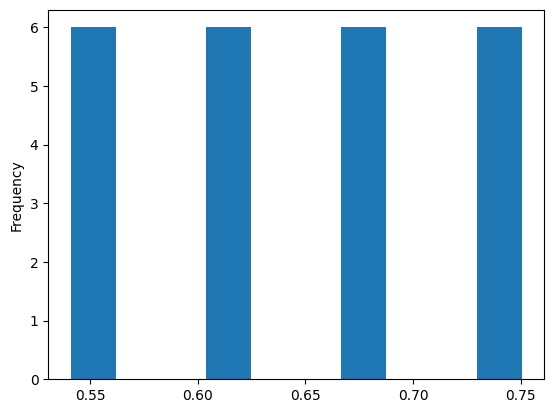

In [29]:
pathological_df["metric_value"].plot.hist()

<Axes: ylabel='Frequency'>

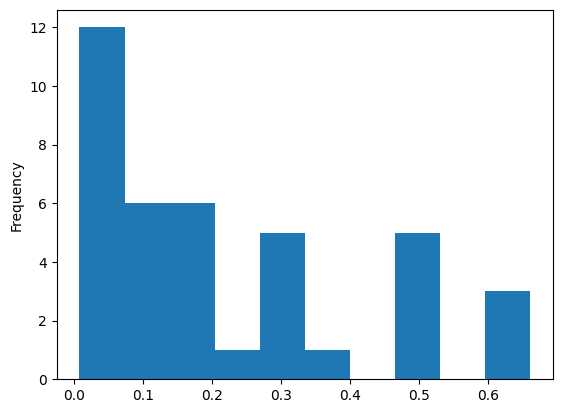

In [30]:
dirichlet_df["metric_value"].plot.hist()

In [31]:
pathological_df['bin'] = pd.cut(pathological_df.loc[:, 'metric_value'], bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=False).astype(int)
dirichlet_df['bin'] = pd.cut(dirichlet_df.loc[:, 'metric_value'],  bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=False).astype(int)

/tmp/ipykernel_645623/1110265417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirichlet_df['bin'] = pd.cut(dirichlet_df.loc[:, 'metric_value'],  bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=False).astype(int)


<Axes: xlabel='bin'>

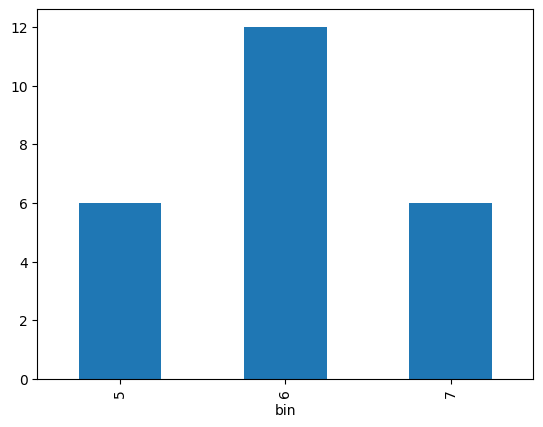

In [34]:
pathological_df['bin'].value_counts().sort_index().plot.bar()

<Axes: xlabel='bin'>

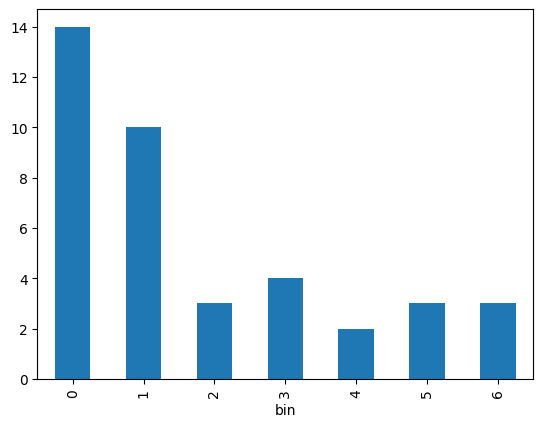

In [35]:
dirichlet_df['bin'].value_counts().sort_index().plot.bar()

In [36]:

# Calculate the correlation for each common bin value
correlations = []
for bin_value in range(5, 6):
    pathological_bin = pathological_df[pathological_df['bin'] == bin_value]
    dirichlet_bin = dirichlet_df[dirichlet_df['bin'] == bin_value]
    correlation = pathological_bin['eval/acc'].corr(dirichlet_bin['eval/acc'])
    correlations.append(correlation)

correlations = np.array(correlations)

# Print the correlations
print(correlations)

[nan]


In [49]:
pathological_df[pathological_df['bin'] == bin_value]['eval/acc']

3     0.8682
7     0.9827
11    0.9809
15    0.9831
19    0.9719
23    0.9519
Name: eval_acc, dtype: float64

In [52]:
dirichlet_df[dirichlet_df['bin'] == bin_value]['eval/acc']

0     0.8843
22    0.9713
29    0.9670
Name: eval_acc, dtype: float64

In [37]:
dirichlet_df

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
1,3,0.3,0.9863,0.388463,3
2,3,1.0,0.9874,0.250478,2
3,3,3.0,0.9886,0.141928,1
4,3,10.0,0.9907,0.078216,0
5,3,100.0,0.9913,0.025358,0
6,3,1000.0,0.9910,0.008000,0
7,10,0.1,0.9174,0.620323,6
8,10,0.3,0.9888,0.482991,4
9,10,1.0,0.9893,0.282998,2


In [38]:
pathological_df

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
0,3,2,0.5725,0.743239,7
1,3,3,0.6383,0.680142,6
2,3,4,0.6797,0.618636,6
3,3,5,0.8682,0.551557,5
4,10,2,0.6746,0.750358,7
5,10,3,0.9392,0.678988,6
6,10,4,0.9660,0.613246,6
7,10,5,0.9827,0.546469,5
8,30,2,0.4091,0.746112,7
9,30,3,0.3563,0.674386,6


In [39]:
pathological_bin

,num_partitions,num_classes_per_partition,eval_acc,metric_value,bin
3,3,5,0.8682,0.551557,5
7,10,5,0.9827,0.546469,5
11,30,5,0.9809,0.542557,5
15,100,5,0.9831,0.541341,5
19,300,5,0.9719,0.541064,5
23,1000,5,0.9519,0.541121,5


In [40]:
dirichlet_bin

,num_partitions,alpha,eval_acc,metric_value,bin
0,3,0.1,0.8843,0.520301,5
22,100,0.3,0.9713,0.507179,5
29,300,0.3,0.9670,0.512800,5
